# **Dataset GRÃ-BRETANHA**

In [0]:
#Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import statsmodels.discrete.discrete_model as sm



from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

In [4]:
df_GB = pd.read_csv('GBvideos.csv', delimiter=',')
df_GB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38916 entries, 0 to 38915
Data columns (total 16 columns):
video_id                  38916 non-null object
trending_date             38916 non-null object
title                     38916 non-null object
channel_title             38916 non-null object
category_id               38916 non-null int64
publish_time              38916 non-null object
tags                      38916 non-null object
views                     38916 non-null int64
likes                     38916 non-null int64
dislikes                  38916 non-null int64
comment_count             38916 non-null int64
thumbnail_link            38916 non-null object
comments_disabled         38916 non-null bool
ratings_disabled          38916 non-null bool
video_error_or_removed    38916 non-null bool
description               38304 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.0+ MB


## Tratamento do DataFrame


In [5]:
df_GB.head().T

,0,1,2,3,4
video_id,Jw1Y-zhQURU,3s1rvMFUweQ,n1WpP7iowLc,PUTEiSjKwJU,rHwDegptbI4
trending_date,17.14.11,17.14.11,17.14.11,17.14.11,17.14.11
title,John Lewis Christmas Ad 2017 - #MozTheMonster,Taylor Swift: …Ready for It? (Live) - SNL,Eminem - Walk On Water (Audio) ft. Beyoncé,Goals from Salford City vs Class of 92 and Fri...,Dashcam captures truck's near miss with child ...
channel_title,John Lewis,Saturday Night Live,EminemVEVO,Salford City Football Club,Cute Girl Videos
category_id,26,24,10,17,25
publish_time,2017-11-10T07:38:29.000Z,2017-11-12T06:24:44.000Z,2017-11-10T17:00:03.000Z,2017-11-13T02:30:38.000Z,2017-11-13T01:45:13.000Z
tags,"christmas|""john lewis christmas""|""john lewis""|...","SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...","Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...","Salford City FC|""Salford City""|""Salford""|""Clas...",[none]
views,7224515,1053632,17158579,27833,9815
likes,55681,25561,787420,193,30
dislikes,10247,2294,43420,12,2


In [0]:
#Fazendo uma cópia do Dataframe
df_GB = df_GB.copy()

In [7]:
df_GB.describe()

,category_id,views,likes,dislikes,comment_count
count,38916.000000,3.891600e+04,3.891600e+04,3.891600e+04,3.891600e+04
mean,16.827937,5.911944e+06,1.345196e+05,7.612560e+03,1.308835e+04
std,7.752728,1.900121e+07,3.499893e+05,5.095683e+04,5.066740e+04
min,1.000000,8.510000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,10.000000,2.515272e+05,5.897000e+03,2.000000e+02,6.790000e+02
50%,20.000000,9.818890e+05,2.518250e+04,8.210000e+02,2.478000e+03
75%,24.000000,3.683628e+06,1.140892e+05,3.357500e+03,9.241500e+03
max,43.000000,4.245389e+08,5.613827e+06,1.944971e+06,1.626501e+06


In [8]:
#Importando o json para ver a category_id
import json

with open('GB_category_id.json', 'r') as f:
  categ_gb = json.load(f)

for k in categ_gb['items']:
  print(k['id'], k['snippet']['title'])

1 Film & Animation
2 Autos & Vehicles
10 Music
15 Pets & Animals
17 Sports
18 Short Movies
19 Travel & Events
20 Gaming
21 Videoblogging
22 People & Blogs
23 Comedy
24 Entertainment
25 News & Politics
26 Howto & Style
27 Education
28 Science & Technology
30 Movies
31 Anime/Animation
32 Action/Adventure
33 Classics
34 Comedy
35 Documentary
36 Drama
37 Family
38 Foreign
39 Horror
40 Sci-Fi/Fantasy
41 Thriller
42 Shorts
43 Shows
44 Trailers


In [0]:
#Analisando a quantidade de categorias 

import json

# open json file with category names
with open('GB_category_id.json', 'r') as f:
  categ_us = json.load(f)

categ_dic = {}

for k in categ_us['items']:
  categ_dic[k['id']]= k['snippet']['title']

#print(categ_dic)

# Creating new column with category names
temp = df_GB.category_id.copy()
temp = temp.astype('str')
df_GB['category_name'] = temp.map(categ_dic)

#print(df.loc[:10, ['category_id', 'category_name']])

Text(0, 0.5, 'Category')

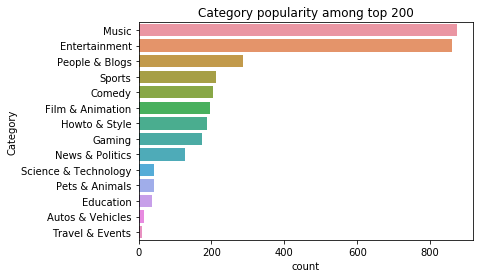

In [11]:
df_GB2 = df_GB.copy()
df_GB2.drop_duplicates('video_id', inplace=True)
sns.countplot(y='category_name', data=df_GB2, order=df_GB2.category_name.value_counts().index )
plt.title('Category popularity among top 200')
plt.ylabel('Category')

### Outliers

In [0]:
#Função para detectar os outliers do novo DataFrame

def detect_outliers(df_GB2,n,features):
    outlier_indices = []
    
    for col in features:

        Q1 = np.percentile(df_GB2[col], 25)
        Q3 = np.percentile(df_GB2[col],75)
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR
        outlier_list_col = df_GB2[(df_GB2[col] < Q1 - outlier_step) | (df_GB2[col] > Q3 + outlier_step )].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers 

In [0]:
Outliers_to_drop = detect_outliers(df_GB2,1,['views', 'likes', 'dislikes', 'comment_count'])

In [15]:
df_GB2.loc[Outliers_to_drop]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,Howto & Style
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,Music
6,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634124,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...,Music
9,9t9u_yPEidY,17.14.11,"Jennifer Lopez - Amor, Amor, Amor (Official Vi...",JenniferLopezVEVO,10,2017-11-10T15:00:00.000Z,"Jennifer Lopez ft. Wisin|""Jennifer Lopez ft. W...",9548677,190084,15015,11473,https://i.ytimg.com/vi/9t9u_yPEidY/default.jpg,False,False,False,"Jennifer Lopez ft. Wisin - Amor, Amor, Amor (O...",Music
17,pz95u3UVpaM,17.14.11,Camila Cabello - Havana (Vertical Video) ft. Y...,CamilaCabelloVEVO,10,2017-11-10T05:01:00.000Z,"camila cabello|""camila""|""young thug""|""havana""|...",5476738,286269,4083,12254,https://i.ytimg.com/vi/pz95u3UVpaM/default.jpg,False,False,False,Havana – Spotify Vertical Video \nVideo Direct...,Music
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33809,r17fqELkv7g,18.15.05,"Azealia Banks Talks New Single, The State Of F...",Breakfast Club Power 105.1 FM,24,2018-05-11T13:09:00.000Z,"the breakfast club|""power1051""|""celebrity news...",1226764,19290,6581,19661,https://i.ytimg.com/vi/r17fqELkv7g/default.jpg,False,False,False,► Listen LIVE: http://power1051fm.com/► Facebo...,Entertainment
35271,zCot9TDoA-M,18.24.05,Official Call of Duty ®: Black Ops 4 Zombies —...,Call of Duty,20,2018-05-17T17:39:53.000Z,"call of duty|""cod""|""activision""|""Zombies""|""Bla...",1248113,68082,2864,9697,https://i.ytimg.com/vi/zCot9TDoA-M/default.jpg,False,False,False,The return of a fan-favorite. The legacy of Zo...,Gaming
35435,wswvNZveNHc,18.25.05,Charmed (The CW) Trailer HD - 2018 Reboot,TV Promos,24,2018-05-17T16:07:29.000Z,[none],1631193,28071,13497,10610,https://i.ytimg.com/vi/wswvNZveNHc/default.jpg,False,False,False,"After the tragic death of their mother, three ...",Entertainment
35921,Ut7e-0X8lds,18.28.05,30-year-old evicted from parents' home speaks ...,CNN,25,2018-05-23T21:15:59.000Z,"latest News|""Happening Now""|""CNN""|""US""|""Newsro...",2232908,7101,6865,24228,https://i.ytimg.com/vi/Ut7e-0X8lds/default.jpg,False,False,False,A judge ruled in favor of parents who wanted t...,News & Politics


In [0]:
#Deletando os Outliers encontrados
df_GB2 = df_GB2.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [17]:
#Percentual dos valores nulos
percent_missing = round(df_GB2.isnull().sum() * 100 / len(df_GB2),2)
missing_value_df = pd.DataFrame({'column_name': df_GB2.columns, 'percent_missing': percent_missing})
missing_value_df = missing_value_df[missing_value_df['percent_missing'] > 0]
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

,column_name,percent_missing
description,description,1.93
category_name,category_name,0.18


In [0]:
#Substituindo os valores na da coluna description e category_name por'Missing' 
df_GB2.description.fillna('Missing', inplace=True)
df_GB2.category_name.fillna('Missing', inplace=True)

In [19]:
# Detectando Valores nulos
df_GB2.isnull().sum()/ len(df_GB2) * 100

video_id                  0.0
trending_date             0.0
title                     0.0
channel_title             0.0
category_id               0.0
publish_time              0.0
tags                      0.0
views                     0.0
likes                     0.0
dislikes                  0.0
comment_count             0.0
thumbnail_link            0.0
comments_disabled         0.0
ratings_disabled          0.0
video_error_or_removed    0.0
description               0.0
category_name             0.0
dtype: float64

Text(0, 0.5, 'category_id')

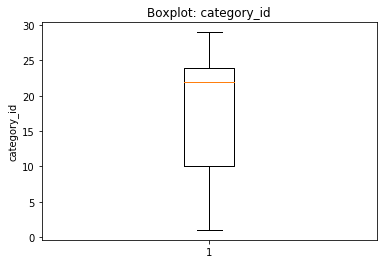

In [20]:
# Bloxpot feature 'category_id'
plt.boxplot(df_GB2['category_id'])
plt.title('Boxplot: category_id')
plt.ylabel('category_id')

### Análise e Visualização

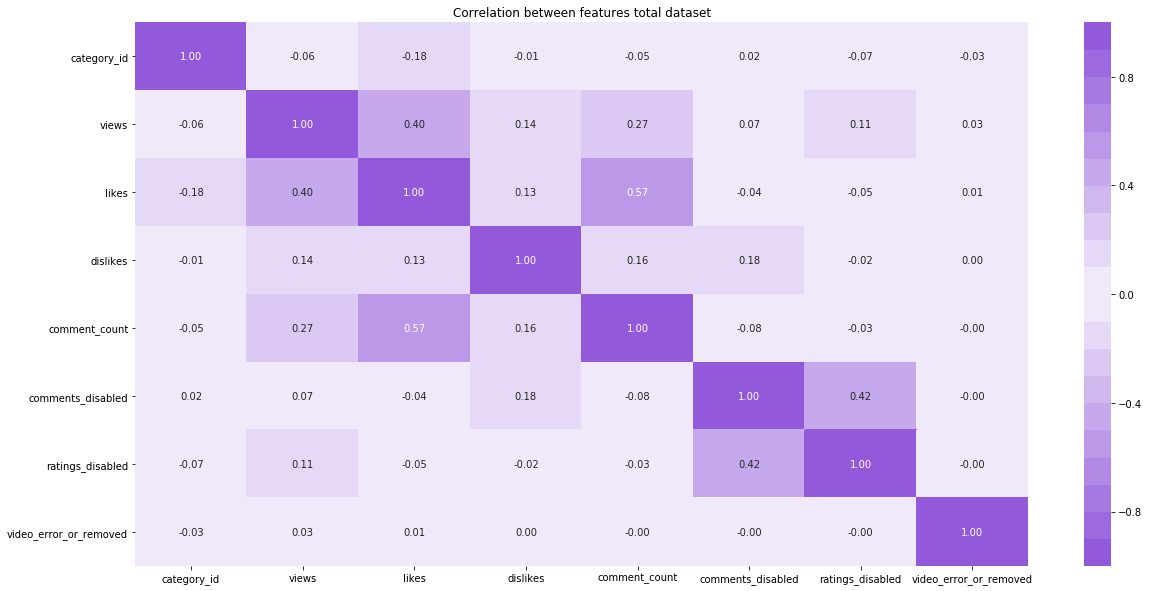

In [21]:
#Correlação de todas as variáveis

plt.figure(figsize=[20,10])
plt.title('Correlation between features total dataset')
sns.heatmap(df_GB2.corr(), annot=True, fmt='.2f', vmin=-1, vmax=1, cmap=sns.diverging_palette(999, 999, n=20))
plt.show()

### Modelando

In [26]:
#Deletando as colunas "genero" e "des_email"
train_bkp = df_GB2.copy()
df_GB2.drop(['video_id', 'trending_date', 'title', 'channel_title', 'publish_time', 'tags', 'thumbnail_link', 'description', 'category_name', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed' ],axis=1,inplace=True)
df_GB2.head()

,category_id,views,likes,dislikes,comment_count
0,24,1053632,25561,2294,2757
1,17,27833,193,12,37
2,25,9815,30,2,30
3,24,1182775,52708,1431,2333
4,22,1164201,57309,749,624


In [0]:
x = df_GB2.drop(columns=['views']).copy()
y = df_GB2['views']

In [29]:
#Separando o dataframe em traino e teste
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1957, 4) (1957,)
(839, 4) (839,)


## Feature Importance

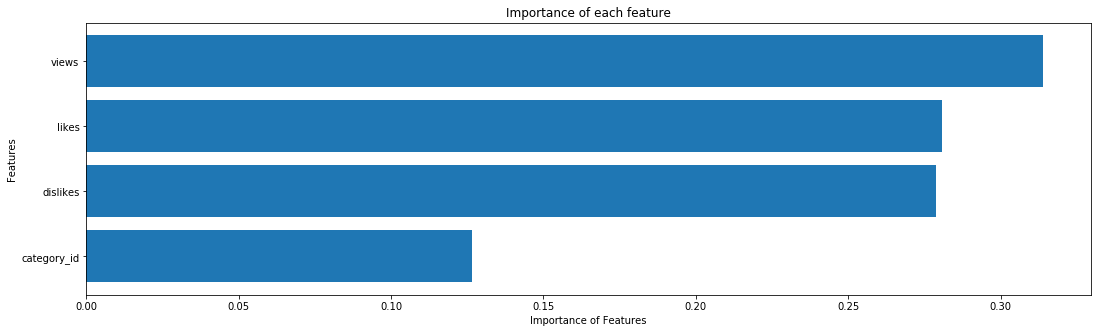

In [30]:
#Construção do Modelo de classificação Random Forest
rfmodel = RandomForestClassifier(random_state=0,n_estimators=450,criterion='gini',n_jobs=-1,max_depth = 8,min_samples_leaf=1,min_samples_split= 11)

#Treinamento do modelo em X_train, Y_train
rfmodel.fit(x_train,y_train)

#Predição do modelo no X_test
y_pred = rfmodel.predict(x_test)
proba = rfmodel.predict_proba(x_test)

#Variáveis Importantes
imp = rfmodel.feature_importances_
names = df_GB2.columns

imp, names = zip(*sorted(zip(imp, names)))

plt.barh(range(len(names)), imp, align = "center")
plt.yticks(range(len(names)), names)
plt.xlabel("Importance of Features")
plt.ylabel("Features")
plt.title("Importance of each feature")
fig=plt.gcf()
fig.set_size_inches(18,5)
plt.show()

In [31]:
a = {'names':names,'imp':imp}
tabela = pd.DataFrame(data=a)
tabela

,names,imp
0,category_id,0.126484
1,dislikes,0.278885
2,likes,0.280685
3,views,0.313946


## Cross Validation


In [38]:
#Applying K-Fold Cross Validation
accuracies = cross_val_score(estimator=rfmodel,X= x_train,y=y_train,cv=2)
print(accuracies)
acc_train = accuracies.mean() #Prints out the  average of the 10 scores.
acc_train

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


[0.00051203 0.        ]


0.0002560163850486431